**Importação das bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, classification_report, recall_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from datetime import datetime

**Carregando a base de dados**

In [ ]:
base = pd.read_csv('bio_output_data_sheet.csv')
base.head(5)

,index,id,varunr,EDATUM,VERKS,AFORM,EXPLAN,Ones,New_Initiation,Duration,Treatment line,Duration_id,First,Switched from ATC,Switched to ATC,Switch order,Dropout_or_break,DMARD Treatment line,DMARD Ones,DMARD New_Initiation,ATC,Product name,Active ingredient,Type,Index.1,New treatment line,Last
0,18183113,1697266,477362,12/1/19,1:1:9,1 Landsting,1,0,NaN,31.0,0,Humira1697266D0,NaN,NaN,NaN,NaN,NaN,Post-DMARD,NaN,NaN,L04AB04,Humira,Adalimumab,Biological,1814068,0:00,NaN
1,18183111,1697266,477362,10/1/19,1:1:9,1 Landsting,1,0,NaN,61.0,0,Humira1697266D0,NaN,NaN,NaN,NaN,NaN,Post-DMARD,NaN,NaN,L04AB04,Humira,Adalimumab,Biological,1814067,0:00,NaN
2,18183110,1697266,477362,9/1/19,1:1:9,1 Landsting,1,0,NaN,30.0,0,Humira1697266D0,NaN,NaN,NaN,NaN,NaN,Post-DMARD,NaN,NaN,L04AB04,Humira,Adalimumab,Biological,1814066,0:00,NaN
3,18183109,1697266,477362,9/1/19,1:1:9,1 Landsting,1,0,NaN,0.0,0,Humira1697266D0,NaN,NaN,NaN,NaN,NaN,Post-DMARD,NaN,NaN,L04AB04,Humira,Adalimumab,Biological,1814065,0:00,NaN
4,18183108,1697266,477362,7/1/19,1:1:9,1 Landsting,1,0,NaN,62.0,0,Humira1697266D0,NaN,NaN,NaN,NaN,NaN,Post-DMARD,NaN,NaN,L04AB04,Humira,Adalimumab,Biological,1814064,0:00,NaN


**Analisando valores nulos**

In [ ]:
base.isna().sum() 

index                        0
id                           0
varunr                       0
EDATUM                       0
VERKS                        0
AFORM                        0
EXPLAN                       0
Ones                         0
New_Initiation          238436
Duration                  5335
Treatment line               0
Duration_id                  0
First                   235747
Switched from ATC       236536
Switched to ATC         236536
Switch order            236536
Dropout_or_break        239792
DMARD Treatment line         0
DMARD Ones              244233
DMARD New_Initiation    244233
ATC                          0
Product name                 0
Active ingredient            0
Type                         0
Index.1                      0
New treatment line           0
Last                    238898
dtype: int64

**Analise dos tipos de dados**

In [ ]:
base.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244233 entries, 0 to 244232
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 244233 non-null  int64  
 1   id                    244233 non-null  int64  
 2   varunr                244233 non-null  int64  
 3   EDATUM                244233 non-null  object 
 4   VERKS                 244233 non-null  object 
 5   AFORM                 244233 non-null  object 
 6   EXPLAN                244233 non-null  int64  
 7   Ones                  244233 non-null  int64  
 8   New_Initiation        5797 non-null    float64
 9   Duration              238898 non-null  float64
 10  Treatment line        244233 non-null  int64  
 11  Duration_id           244233 non-null  object 
 12  First                 8486 non-null    object 
 13  Switched from ATC     7697 non-null    object 
 14  Switched to ATC       7697 non-null    object 
 15  

***Eliminando colunas e valores nulos***

In [ ]:
base = base.loc[pd.notnull(base['Switched to ATC'])] # eliminando linhas nulas
base = base.loc[pd.notnull(base['Duration'])] # Também optamos por eliminar linhas nulas nessa coluna, pois continha apenas 296 ocorrencias nulas, diante de um dataset grande
                                              # cremos que não irá atrapalhar no resultado pois ainda restam 7401 linhas.

X = base.drop(['Product name','index','varunr','VERKS','Duration_id','ATC','Index.1', # nessa linha removemos as colunas solicitadas no documento compartilhado
                      'Dropout_or_break','First','DMARD Ones','DMARD New_Initiation','Last','New_Initiation',], axis=1) # removemos mais algumas, pois mesmo após eliminar linhas nulas em duas colunas
#  verificamos conforme os dados abaixo, que ainda foram encontradas muitas ocorrencias nulas nessas colunas, de modo que fica impossivel eliminar ou substituir sem que afete drasticamente o modelo.

y = base['Switched to ATC']

X.isna().sum()

id                      0
EDATUM                  0
AFORM                   0
EXPLAN                  0
Ones                    0
Duration                0
Treatment line          0
Switched from ATC       0
Switched to ATC         0
Switch order            0
DMARD Treatment line    0
Active ingredient       0
Type                    0
New treatment line      0
dtype: int64

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7401 entries, 35 to 244215
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7401 non-null   int64  
 1   EDATUM                7401 non-null   object 
 2   AFORM                 7401 non-null   object 
 3   EXPLAN                7401 non-null   int64  
 4   Ones                  7401 non-null   int64  
 5   Duration              7401 non-null   float64
 6   Treatment line        7401 non-null   int64  
 7   Switched from ATC     7401 non-null   object 
 8   Switched to ATC       7401 non-null   object 
 9   Switch order          7401 non-null   float64
 10  DMARD Treatment line  7401 non-null   object 
 11  Active ingredient     7401 non-null   object 
 12  Type                  7401 non-null   object 
 13  New treatment line    7401 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 867.3+ KB


In [ ]:
#analisando a coluna Duration percebemos que possue valores relevantes para o treinamento, entretanto possui alguns valores nulos,
#dada a relevancia do dado substituimos os valores nulos pelo valor que mais se repete
#X.loc[pd.isnull(X['Duration'])]
#X['Duration'].value_counts() #aqui verifcamos que o valor 31.0 se repete 1921
#valor = {'Duration': 31.0} #apontamos a coluna e o valor que ira substituir os valore nulos
#X = X.fillna(value=valor) #fizemos a substituição dos valores nulos
#X.head(5)

#2 - 7 - 9 - 10 - 11 - 12 - 13 indice das colunas que precisam ser convertidas em valores numericos
#EDATUM - converter em milesegundos
#New treatment line - ver o que fazer com essa coluna
X['EDATUM'] = pd.to_datetime(X['EDATUM']) #convertendo em datetime, só falta converter para milisegundos, com fé chegamos la rsrs
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7401 entries, 35 to 244215
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    7401 non-null   int64         
 1   EDATUM                7401 non-null   datetime64[ns]
 2   AFORM                 7401 non-null   object        
 3   EXPLAN                7401 non-null   int64         
 4   Ones                  7401 non-null   int64         
 5   Duration              7401 non-null   float64       
 6   Treatment line        7401 non-null   int64         
 7   Switched from ATC     7401 non-null   object        
 8   Switched to ATC       7401 non-null   object        
 9   Switch order          7401 non-null   float64       
 10  DMARD Treatment line  7401 non-null   object        
 11  Active ingredient     7401 non-null   object        
 12  Type                  7401 non-null   object        
 13  New treatment l

***Convertendo coluna EDATUM em milisegundos***

In [ ]:
for x in X['EDATUM']:
  X['EDATUM'] = x.timestamp()*1000

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7401 entries, 35 to 244215
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7401 non-null   int64  
 1   EDATUM                7401 non-null   float64
 2   AFORM                 7401 non-null   object 
 3   EXPLAN                7401 non-null   int64  
 4   Ones                  7401 non-null   int64  
 5   Duration              7401 non-null   float64
 6   Treatment line        7401 non-null   int64  
 7   Switched from ATC     7401 non-null   object 
 8   Switched to ATC       7401 non-null   object 
 9   Switch order          7401 non-null   float64
 10  DMARD Treatment line  7401 non-null   object 
 11  Active ingredient     7401 non-null   object 
 12  Type                  7401 non-null   object 
 13  New treatment line    7401 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 867.3+ KB


**Quantidade de atributos da coluna Switched to ATC antes do OneHotEncoder**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


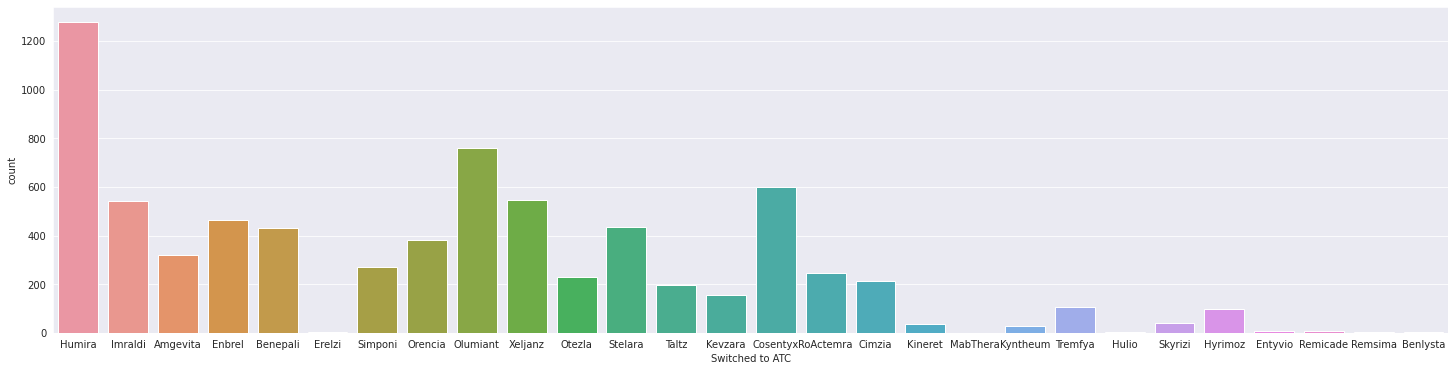

In [ ]:
plt.figure(figsize = (25,6))
sns.set_style('darkgrid')
sns.countplot(y)

**Capturando e transformando em variváveis do tipo Dummy, as Coluna Switched from ATC e to ATC para posterior implementação do EDA**

In [ ]:
EDASwit = X[['Switched from ATC','Switched to ATC']]

EDASwit = pd.get_dummies(EDASwit, columns=['Switched from ATC', 'Switched to ATC'])


**Criando a Variavel PREVISORES e TARGET**

1.   Item da lista

1.   Item da lista

1.   Item da lista
2.   Item da lista


2.   Item da lista


2.   Item da lista



In [ ]:
previsores = X
target = y

**Quantidade de atributos da coluna Switched from ATC antes do OneHotEncoder**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


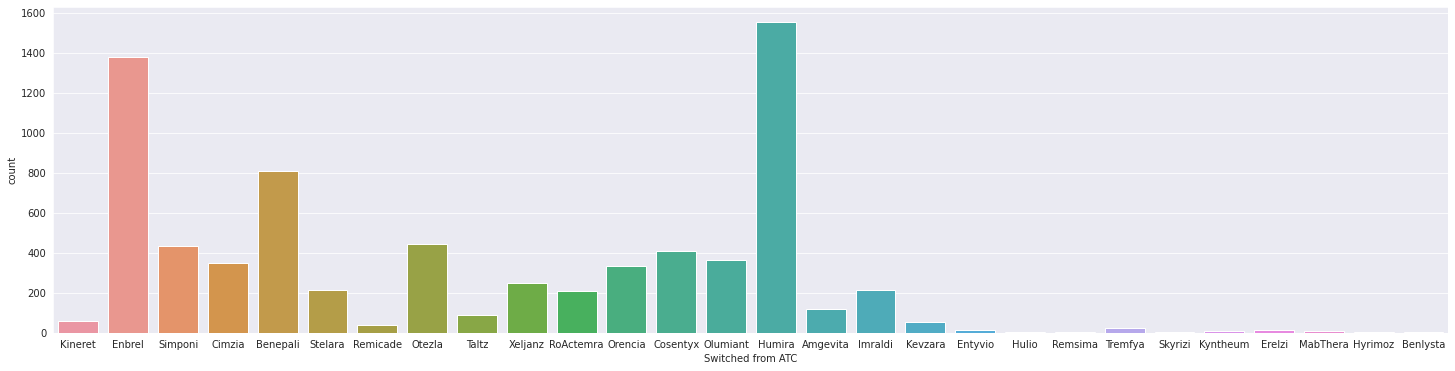

In [ ]:
plt.figure(figsize = (25,6))
sns.set_style('darkgrid')
sns.countplot(X['Switched from ATC'])

**Label Encoder das variaveis categóricas da base previsores**

In [ ]:
encoder = LabelEncoder()

previsores['AFORM'] = encoder.fit_transform(previsores['AFORM'])
previsores['Switched from ATC'] = encoder.fit_transform(previsores['Switched from ATC'])
previsores['Switched to ATC_Label'] = encoder.fit_transform(previsores['Switched to ATC'])
previsores['DMARD Treatment line'] = encoder.fit_transform(previsores['DMARD Treatment line'])
previsores['Active ingredient'] = encoder.fit_transform(previsores['Active ingredient'])
previsores['Type'] = encoder.fit_transform(previsores['Type'])
previsores['New treatment line'] = encoder.fit_transform(previsores['New treatment line'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


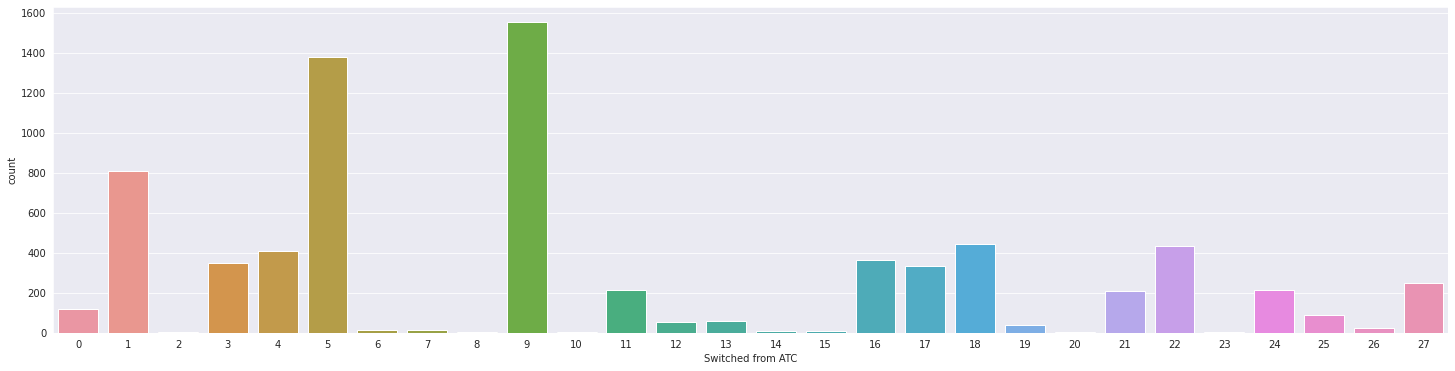

In [ ]:
plt.figure(figsize = (25,6))
sns.set_style('darkgrid')
sns.countplot(X['Switched from ATC'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


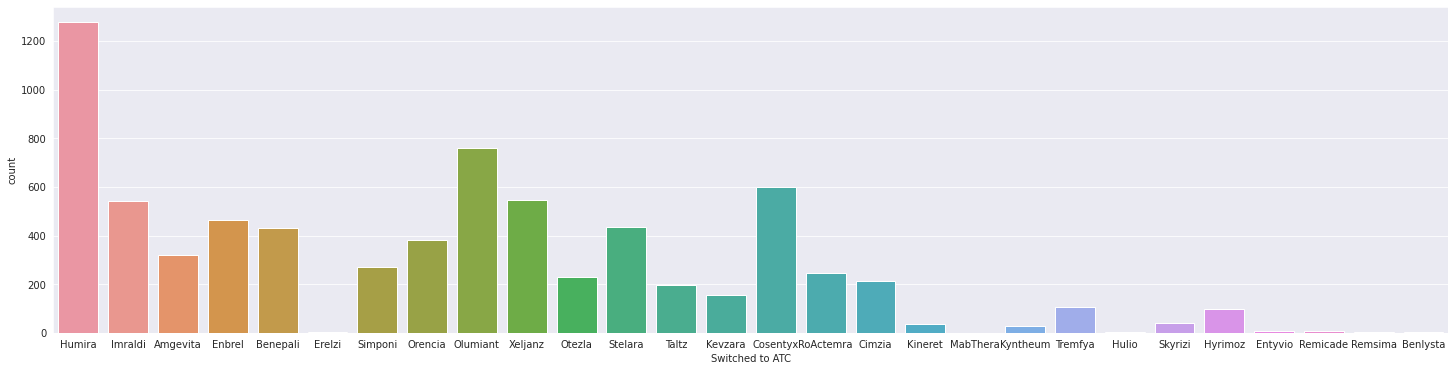

In [ ]:
plt.figure(figsize = (25,6))
sns.set_style('darkgrid')
sns.countplot(X['Switched to ATC'])

**Matriz de Correlação do Dataset**

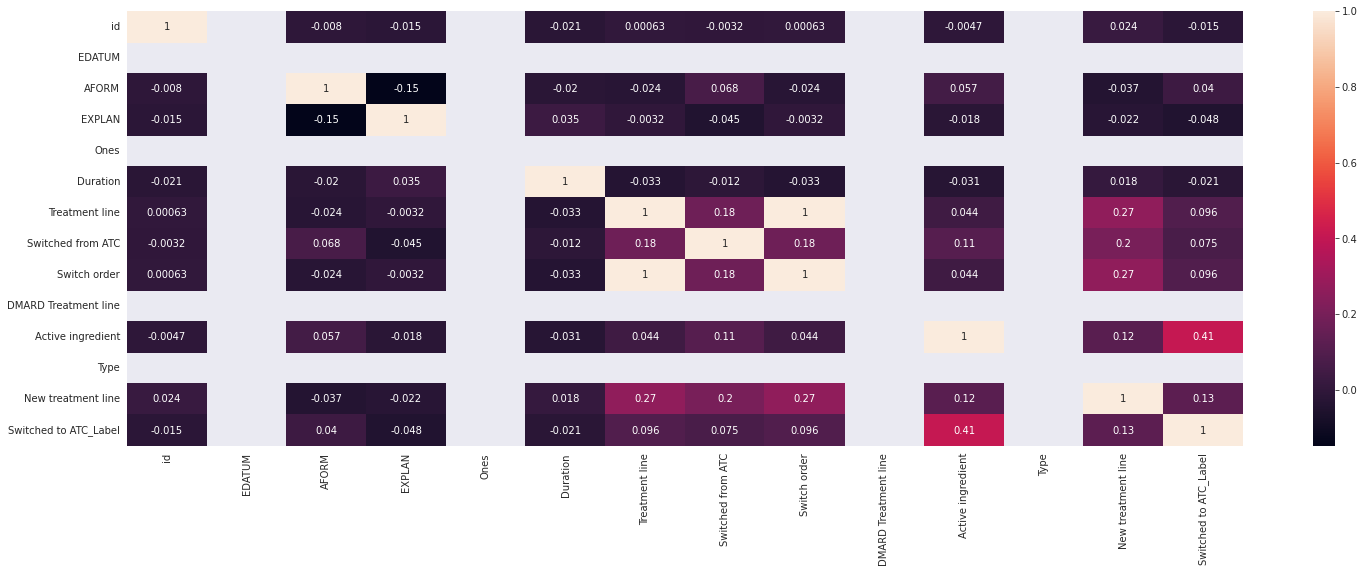

In [ ]:
correlacao = previsores.corr()
plt.figure(figsize = (25,8))
sns.heatmap(correlacao, xticklabels=correlacao.columns, yticklabels=correlacao.columns, annot=True)

**Mapa térmico de correlação das features**

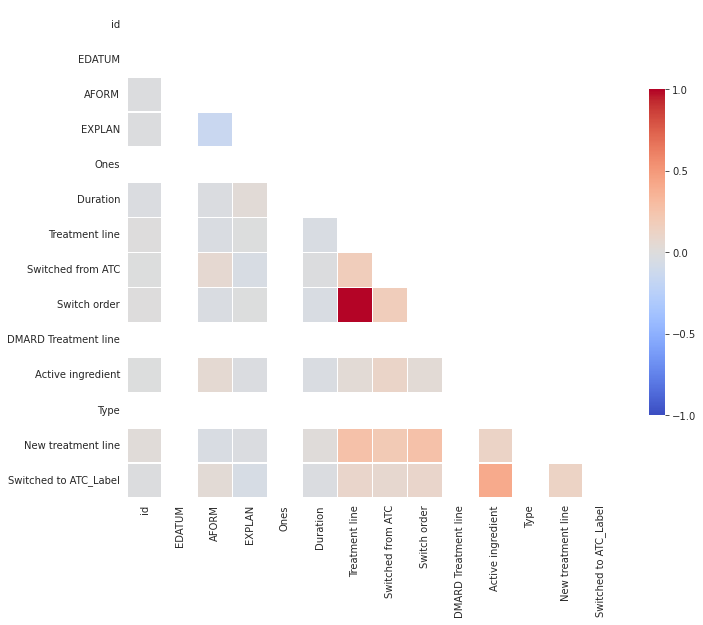

In [ ]:
mask = np.zeros_like(correlacao, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(correlacao, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(correlacao.columns, rotation = 0)
ax.set_xticklabels(correlacao.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

**Excluindo as colunas Switched to ATC e Switched to ATC_Label da base previsores**

In [ ]:
#X = X.drop(columns=['Switched to ATC_Label'])
previsores = previsores.drop(columns=['Switched to ATC','Switched to ATC_Label'])
previsores.head()

,id,EDATUM,AFORM,EXPLAN,Ones,Duration,Treatment line,Switched from ATC,Switch order,DMARD Treatment line,Active ingredient,Type,New treatment line
35,1580026,1.569888e+12,0,1,1,0.0,1,13,1.0,0,1,0,11
136,1275489,1.569888e+12,0,1,1,30.0,1,5,1.0,0,1,0,11
171,1142262,1.569888e+12,0,1,1,28.0,1,5,1.0,0,1,0,11
246,937724,1.569888e+12,0,1,1,31.0,1,5,1.0,0,1,0,11
308,666014,1.569888e+12,0,1,1,30.0,1,5,1.0,0,1,0,11


`**Features Importantes**

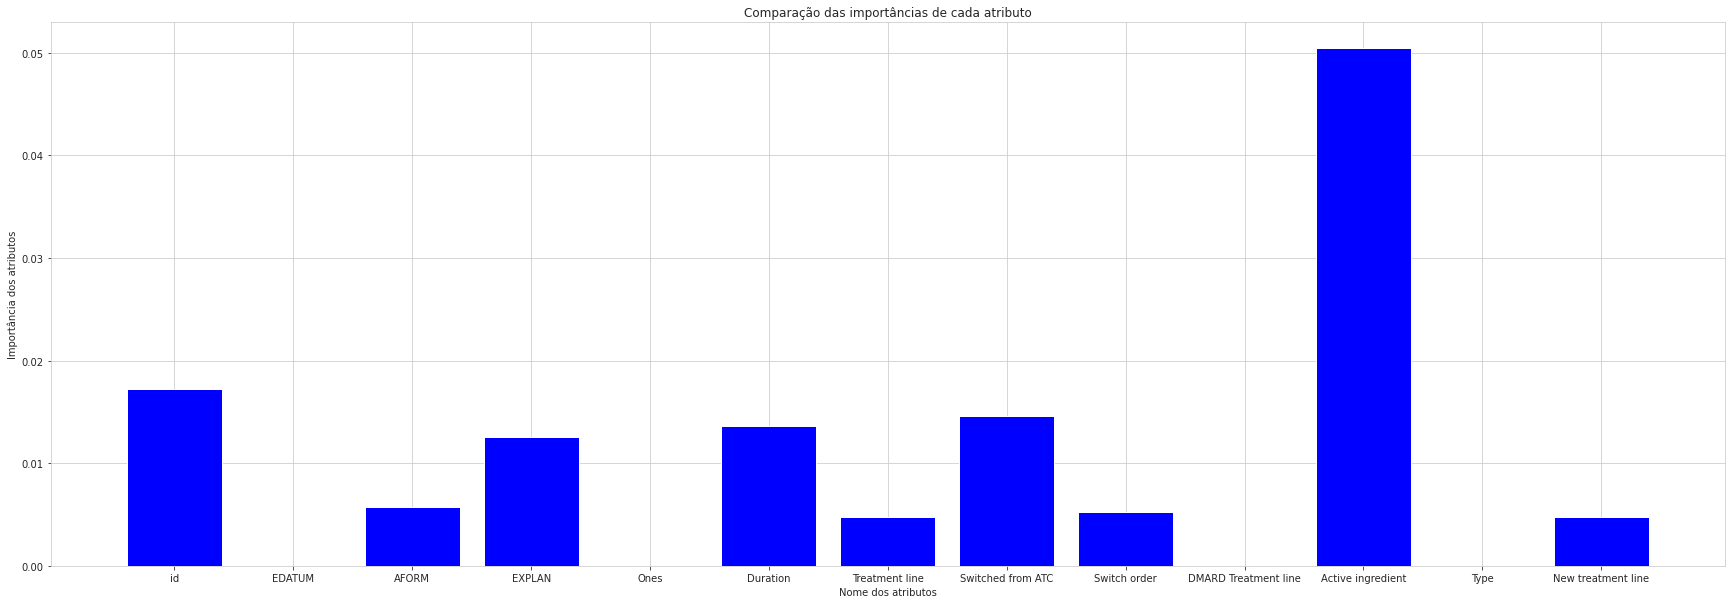

In [ ]:
forest_clf = ExtraTreesClassifier(n_estimators=250, random_state=420)
forest_clf.fit(previsores,target)

imp_features = forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis = 0)
 
plt.figure(figsize = (30,10))
plt.bar(previsores.columns, std, color = 'blue') 
plt.xlabel('Nome dos atributos') 
plt.ylabel('Importância dos atributos') 
plt.title('Comparação das importâncias de cada atributo') 
plt.show()

**OneHotEncoder das colunas Switched from ATC e to ATC**

In [ ]:
# Erro: E nessa linha, vcs fizeram onehot em cima de colunas que ja foram convertidas para label encoding.

#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer

## Somente a Switched from ATC e Switched to ATC, passam por OneHot.
#ohe = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['AFORM','Switched from ATC','DMARD Treatment line',
#                                                                  'Active ingredient','Type','New treatment line'])],remainder='passthrough')
#previsores = ohe.fit_transform(previsores)
# After OneHot
#pd.DataFrame.sparse.from_spmatrix(previsores)


In [ ]:
# Correção, Onehot correto.
#X = pd.get_dummies(X, columns=['Switched from ATC', 'Switched to ATC'])
#X.head()
previsores = pd.get_dummies(previsores, columns=['Switched from ATC',])
target = pd.get_dummies(target, columns=['Switched to ATC',])
previsores.head()

,id,EDATUM,AFORM,EXPLAN,Ones,Duration,Treatment line,Switch order,DMARD Treatment line,Active ingredient,Type,New treatment line,Switched from ATC_0,Switched from ATC_1,Switched from ATC_2,Switched from ATC_3,Switched from ATC_4,Switched from ATC_5,Switched from ATC_6,Switched from ATC_7,Switched from ATC_8,Switched from ATC_9,Switched from ATC_10,Switched from ATC_11,Switched from ATC_12,Switched from ATC_13,Switched from ATC_14,Switched from ATC_15,Switched from ATC_16,Switched from ATC_17,Switched from ATC_18,Switched from ATC_19,Switched from ATC_20,Switched from ATC_21,Switched from ATC_22,Switched from ATC_23,Switched from ATC_24,Switched from ATC_25,Switched from ATC_26,Switched from ATC_27
35,1580026,1.569888e+12,0,1,1,0.0,1,1.0,0,1,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
136,1275489,1.569888e+12,0,1,1,30.0,1,1.0,0,1,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171,1142262,1.569888e+12,0,1,1,28.0,1,1.0,0,1,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
246,937724,1.569888e+12,0,1,1,31.0,1,1.0,0,1,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308,666014,1.569888e+12,0,1,1,30.0,1,1.0,0,1,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
target.head()

,Amgevita,Benepali,Benlysta,Cimzia,Cosentyx,Enbrel,Entyvio,Erelzi,Hulio,Humira,Hyrimoz,Imraldi,Kevzara,Kineret,Kyntheum,MabThera,Olumiant,Orencia,Otezla,Remicade,Remsima,RoActemra,Simponi,Skyrizi,Stelara,Taltz,Tremfya,Xeljanz
35,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
136,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
246,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**EDA das colunas Switched from ATC e to ATC após o OneHotEnconder**

In [ ]:
#Verificando possíveis valores NaN

EDASwit.isna().sum()

Switched from ATC_Amgevita     0
Switched from ATC_Benepali     0
Switched from ATC_Benlysta     0
Switched from ATC_Cimzia       0
Switched from ATC_Cosentyx     0
Switched from ATC_Enbrel       0
Switched from ATC_Entyvio      0
Switched from ATC_Erelzi       0
Switched from ATC_Hulio        0
Switched from ATC_Humira       0
Switched from ATC_Hyrimoz      0
Switched from ATC_Imraldi      0
Switched from ATC_Kevzara      0
Switched from ATC_Kineret      0
Switched from ATC_Kyntheum     0
Switched from ATC_MabThera     0
Switched from ATC_Olumiant     0
Switched from ATC_Orencia      0
Switched from ATC_Otezla       0
Switched from ATC_Remicade     0
Switched from ATC_Remsima      0
Switched from ATC_RoActemra    0
Switched from ATC_Simponi      0
Switched from ATC_Skyrizi      0
Switched from ATC_Stelara      0
Switched from ATC_Taltz        0
Switched from ATC_Tremfya      0
Switched from ATC_Xeljanz      0
Switched to ATC_Amgevita       0
Switched to ATC_Benepali       0
Switched t

In [ ]:
#Verificando possíveis valores NULOS

EDASwit.isnull().sum()

Switched from ATC_Amgevita     0
Switched from ATC_Benepali     0
Switched from ATC_Benlysta     0
Switched from ATC_Cimzia       0
Switched from ATC_Cosentyx     0
Switched from ATC_Enbrel       0
Switched from ATC_Entyvio      0
Switched from ATC_Erelzi       0
Switched from ATC_Hulio        0
Switched from ATC_Humira       0
Switched from ATC_Hyrimoz      0
Switched from ATC_Imraldi      0
Switched from ATC_Kevzara      0
Switched from ATC_Kineret      0
Switched from ATC_Kyntheum     0
Switched from ATC_MabThera     0
Switched from ATC_Olumiant     0
Switched from ATC_Orencia      0
Switched from ATC_Otezla       0
Switched from ATC_Remicade     0
Switched from ATC_Remsima      0
Switched from ATC_RoActemra    0
Switched from ATC_Simponi      0
Switched from ATC_Skyrizi      0
Switched from ATC_Stelara      0
Switched from ATC_Taltz        0
Switched from ATC_Tremfya      0
Switched from ATC_Xeljanz      0
Switched to ATC_Amgevita       0
Switched to ATC_Benepali       0
Switched t

In [ ]:
#Descrição dos valores existentes na contagem, média e valores mínimo e maximo do desvio padrão

EDASwit.describe()

,Switched from ATC_Amgevita,Switched from ATC_Benepali,Switched from ATC_Benlysta,Switched from ATC_Cimzia,Switched from ATC_Cosentyx,Switched from ATC_Enbrel,Switched from ATC_Entyvio,Switched from ATC_Erelzi,Switched from ATC_Hulio,Switched from ATC_Humira,Switched from ATC_Hyrimoz,Switched from ATC_Imraldi,Switched from ATC_Kevzara,Switched from ATC_Kineret,Switched from ATC_Kyntheum,Switched from ATC_MabThera,Switched from ATC_Olumiant,Switched from ATC_Orencia,Switched from ATC_Otezla,Switched from ATC_Remicade,Switched from ATC_Remsima,Switched from ATC_RoActemra,Switched from ATC_Simponi,Switched from ATC_Skyrizi,Switched from ATC_Stelara,Switched from ATC_Taltz,Switched from ATC_Tremfya,Switched from ATC_Xeljanz,Switched to ATC_Amgevita,Switched to ATC_Benepali,Switched to ATC_Benlysta,Switched to ATC_Cimzia,Switched to ATC_Cosentyx,Switched to ATC_Enbrel,Switched to ATC_Entyvio,Switched to ATC_Erelzi,Switched to ATC_Hulio,Switched to ATC_Humira,Switched to ATC_Hyrimoz,Switched to ATC_Imraldi,Switched to ATC_Kevzara,Switched to ATC_Kineret,Switched to ATC_Kyntheum,Switched to ATC_MabThera,Switched to ATC_Olumiant,Switched to ATC_Orencia,Switched to ATC_Otezla,Switched to ATC_Remicade,Switched to ATC_Remsima,Switched to ATC_RoActemra,Switched to ATC_Simponi,Switched to ATC_Skyrizi,Switched to ATC_Stelara,Switched to ATC_Taltz,Switched to ATC_Tremfya,Switched to ATC_Xeljanz
count,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.00000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000
mean,0.015944,0.109039,0.000540,0.047156,0.055263,0.186461,0.002027,0.001892,0.000405,0.209701,0.000270,0.028780,0.007567,0.007837,0.001486,0.000946,0.048912,0.044859,0.059722,0.005405,0.000405,0.028510,0.058641,0.000405,0.028915,0.01189,0.003378,0.033644,0.043373,0.057965,0.000676,0.028645,0.080800,0.062559,0.000946,0.000540,0.000540,0.172544,0.013377,0.073368,0.020943,0.004999,0.003918,0.000135,0.102554,0.051344,0.031077,0.000811,0.000270,0.033104,0.036482,0.005675,0.058641,0.026753,0.014322,0.073639
std,0.125267,0.311710,0.023243,0.211986,0.228508,0.389505,0.044977,0.043455,0.020131,0.407123,0.016438,0.167199,0.086662,0.088184,0.038526,0.030742,0.215699,0.207008,0.236986,0.073323,0.020131,0.166435,0.234967,0.020131,0.167579,0.10840,0.058026,0.180324,0.203708,0.233693,0.025985,0.166817,0.272546,0.242185,0.030742,0.023243,0.023243,0.377878,0.114889,0.260758,0.143204,0.070534,0.062479,0.011624,0.303396,0.220714,0.173537,0.028463,0.016438,0.178919,0.187498,0.075123,0.234967,0.161372,0.118824,0.261200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
#Quantidade de colunas criadas após o o OnHotEncoder das features Swiched from ATC e to ATC

EDASwit.shape

(7401, 56)

In [ ]:
#Quantidade de valores únicos para cada atributo [0 ou 1]

EDASwit.nunique()

Switched from ATC_Amgevita     2
Switched from ATC_Benepali     2
Switched from ATC_Benlysta     2
Switched from ATC_Cimzia       2
Switched from ATC_Cosentyx     2
Switched from ATC_Enbrel       2
Switched from ATC_Entyvio      2
Switched from ATC_Erelzi       2
Switched from ATC_Hulio        2
Switched from ATC_Humira       2
Switched from ATC_Hyrimoz      2
Switched from ATC_Imraldi      2
Switched from ATC_Kevzara      2
Switched from ATC_Kineret      2
Switched from ATC_Kyntheum     2
Switched from ATC_MabThera     2
Switched from ATC_Olumiant     2
Switched from ATC_Orencia      2
Switched from ATC_Otezla       2
Switched from ATC_Remicade     2
Switched from ATC_Remsima      2
Switched from ATC_RoActemra    2
Switched from ATC_Simponi      2
Switched from ATC_Skyrizi      2
Switched from ATC_Stelara      2
Switched from ATC_Taltz        2
Switched from ATC_Tremfya      2
Switched from ATC_Xeljanz      2
Switched to ATC_Amgevita       2
Switched to ATC_Benepali       2
Switched t

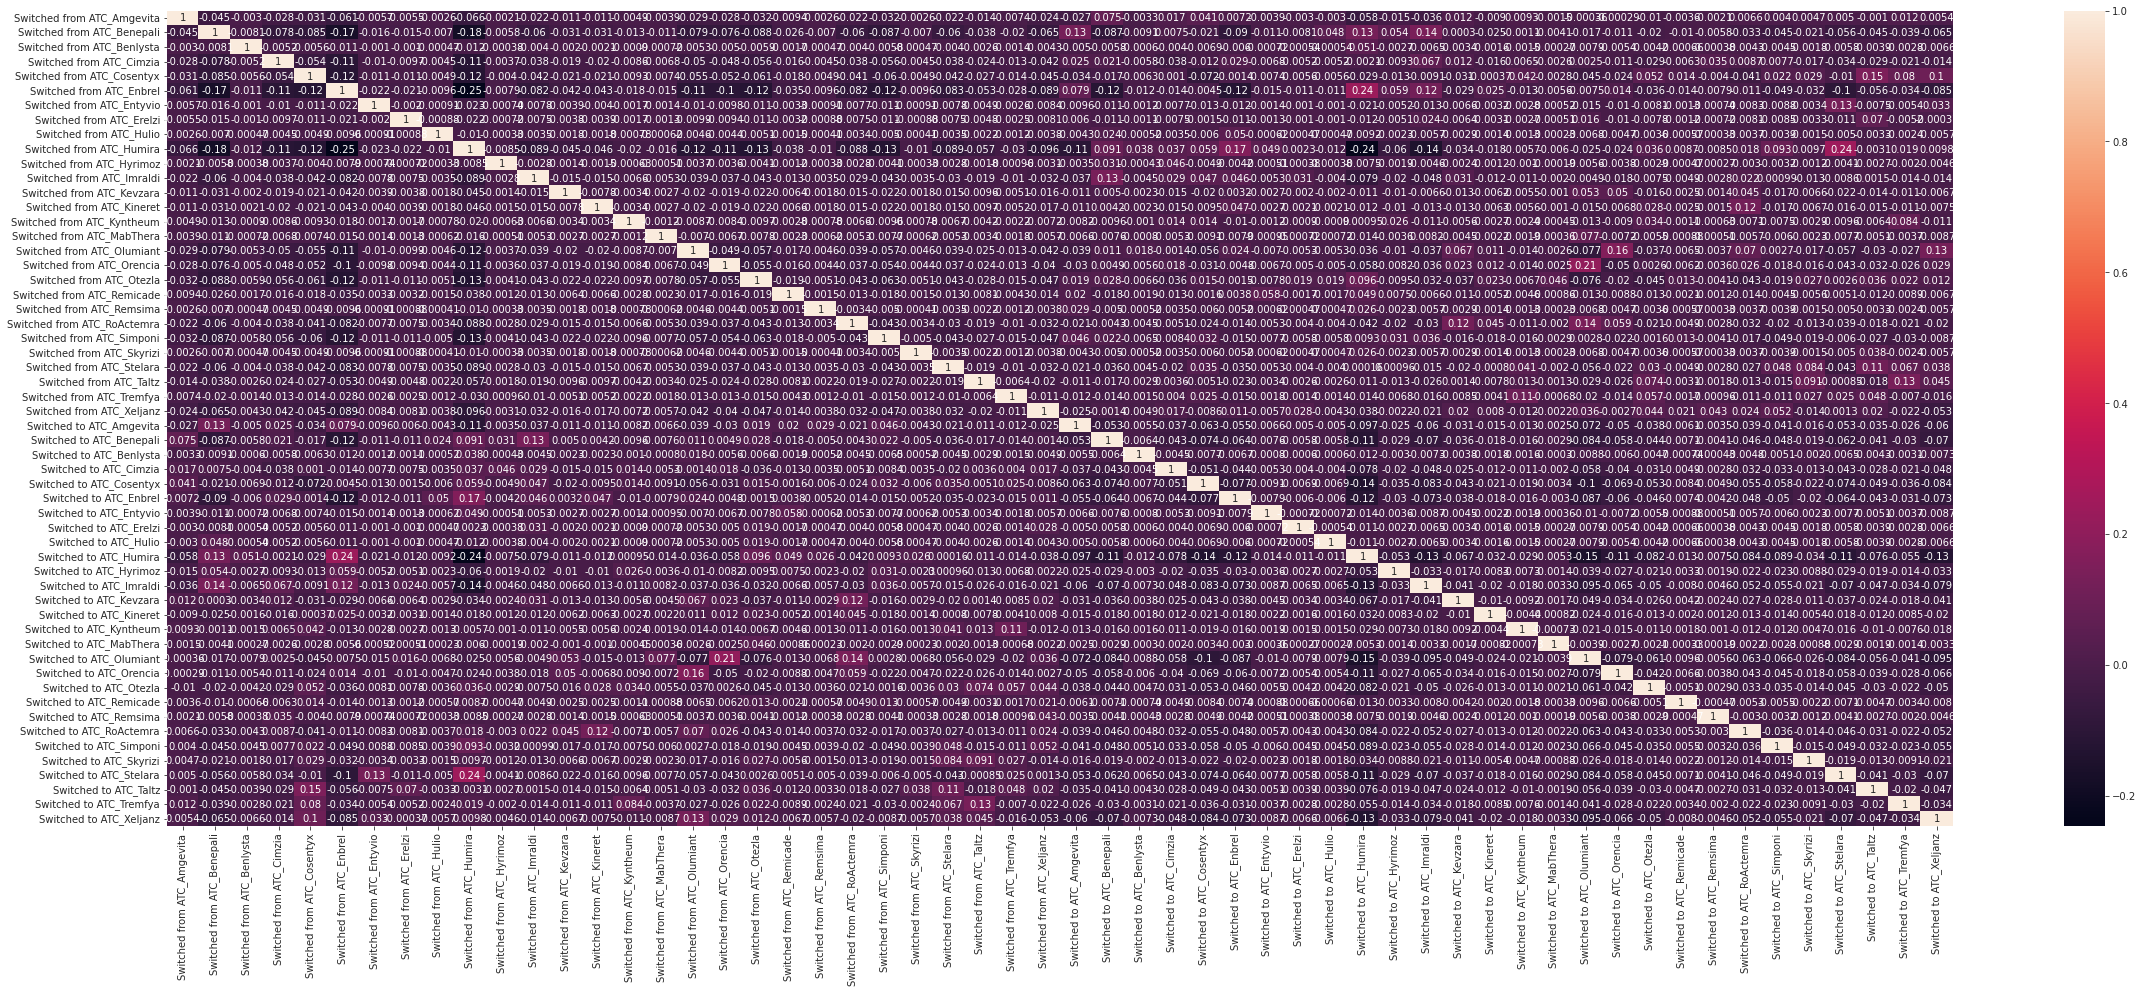

In [ ]:
# Matriz de correlação das colunas Switched from e to ATC

correlacao = EDASwit.corr()
plt.figure(figsize = (40,15))
sns.heatmap(correlacao, xticklabels=correlacao.columns, yticklabels=correlacao.columns, annot=True)

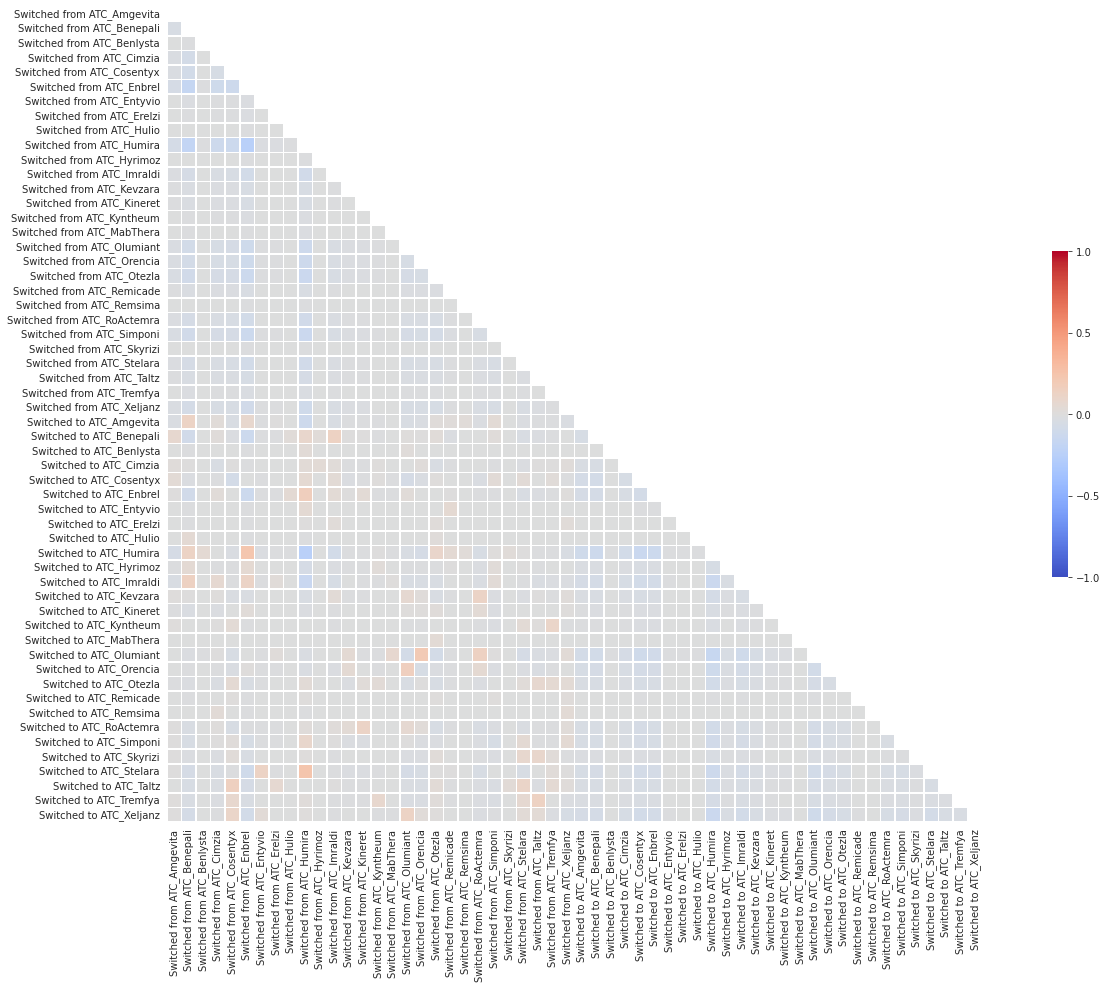

In [ ]:
#Mapa térmico de correlação das colunas Switched from e to ATC

mask = np.zeros_like(correlacao, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(25, 15)) 
heatmap = sns.heatmap(correlacao, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(correlacao.columns, rotation = 0)
ax.set_xticklabels(correlacao.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

**Separando o Dataset em base de treinamento e teste**




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(previsores, target, test_size = 0.20)

**Treinando o Dataset com o algoritmo RandomForestClassifier**

In [ ]:
modeloRandom = RandomForestClassifier()
modeloRandom.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# realizando predição na base de dados de teste

previsoes = modeloRandom.predict(X_test)

In [ ]:
# Calculando o Score de acerto na base de dados de treinamento

modeloRandom.score(X_train, y_train)

0.9998310810810811

In [ ]:
# Calculando o Score de acerto na base de dados de teste

modeloRandom.score(X_test, y_test)

0.5050641458474004

In [ ]:
# Matriz de confusão

matriz = confusion_matrix(y_test.values.argmax(axis=1), previsoes.argmax(axis=1))

plt.figure(figsize = (40,40))
sns.heatmap(matriz, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
# F1 Score

F1_Score = f1_score(y_test,previsoes, pos_label='positive', average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
F1_Score

0.6330935251798562

In [ ]:
# MCC Score

MCC_Score = matthews_corrcoef(y_test.values.argmax(axis=1), previsoes.argmax(axis=1), sample_weight=None)

MCC_Score

0.5308101757010071

In [ ]:
# Sensitivity

sensitivity = recall_score(y_test, previsoes, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity

0.5050641458474004

In [ ]:
# Specificity

specificity = matriz[1,1] / (matriz[1,0] + matriz[1,1]) # VN/(VN+FP)

specificity

0.28169014084507044

In [ ]:
# Accuracy Score

Accuracy_Score = accuracy_score(y_test,previsoes)

Accuracy_Score

0.5050641458474004

In [ ]:
# Precision Score

Precision_Score = precision_score(y_test,previsoes, pos_label='positive', average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
Precision_Score

0.8480725623582767

**Treinando o Dataset com o algoritmo MultiOutputClassifier**

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost.sklearn import XGBClassifier

modeloMulti = MultiOutputClassifier(estimator=XGBClassifier())

modeloMulti.fit(X_train, y_train)

previsoes = modeloMulti.predict(X_test)

In [ ]:
Accuracy = accuracy_score(y_test, previsoes)

Accuracy

0.812288993923025

In [ ]:
MCC_Score = matthews_corrcoef(y_test.values.argmax(axis=1), previsoes.argmax(axis=1), sample_weight=None)

MCC_Score

0.834967913310136

In [ ]:
F1_Score = f1_score(y_test,previsoes, pos_label='positive', average='micro')

F1_Score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


0.8563300142247511

In [ ]:
# Sensitivity

sensitivity = recall_score(y_test, previsoes, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') # VP/(VP+FN)

sensitivity

0.812964213369345

In [ ]:
# Specificity

specificity = matriz[1,1] / (matriz[1,0] + matriz[1,1]) # VN/(VN+FP)

specificity

0.28169014084507044

**Implementação do modelo de Rede Neural com camadas ocultas**

In [ ]:
#Criação da rede neural

modelo = Sequential()

In [ ]:
#Adicionando as camadas da Rede Neural

modelo.add(Dense(units=34, kernel_initializer='normal', activation='relu', input_dim = 40)) # Camada de entrada
modelo.add(Dropout(0.3))

modelo.add(Dense(units=34, kernel_initializer='normal', activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=34, kernel_initializer='normal', activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=28, activation='softmax')) # Camada de saída

In [ ]:
#Compilando a Rede Neural

modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
#Efetuando o treinamento da Rede Neural

#modelo.fit(X_train, y_train, epochs=100, batch_size=20)
from keras.callbacks import  EarlyStopping

# Tiago: Usando earlystop para aumentar a acuracia, evitando overfit.
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)
modelo.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

modelo.summary()

Epoch 1/150
185/185 [==============================] - 1s 4ms/step - loss: 316730496.0000 - categorical_accuracy: 0.0738 - val_loss: 3.2470 - val_categorical_accuracy: 0.1040
Epoch 2/150
185/185 [==============================] - 0s 2ms/step - loss: 7967424.5000 - categorical_accuracy: 0.1047 - val_loss: 3.1359 - val_categorical_accuracy: 0.1040
Epoch 3/150
185/185 [==============================] - 0s 2ms/step - loss: 2745091.2500 - categorical_accuracy: 0.1130 - val_loss: 3.0509 - val_categorical_accuracy: 0.1040
Epoch 4/150
185/185 [==============================] - 0s 2ms/step - loss: 753389.6875 - categorical_accuracy: 0.1289 - val_loss: 2.9875 - val_categorical_accuracy: 0.1668
Epoch 5/150
185/185 [==============================] - 0s 2ms/step - loss: 417655.6562 - categorical_accuracy: 0.1720 - val_loss: 2.9395 - val_categorical_accuracy: 0.1668
Epoch 6/150
185/185 [==============================] - 0s 2ms/step - loss: 280696.8125 - categorical_accuracy: 0.1731 - val_loss: 2.935

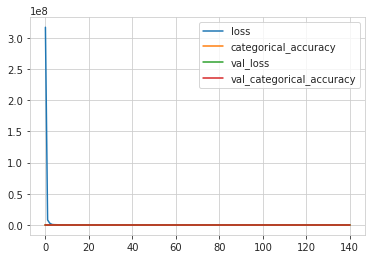

In [ ]:
model_loss = pd.DataFrame(modelo.history.history)
model_loss.plot()

In [ ]:
previsoes = modelo.predict(X_test)